In [3]:
import os
import pandas as pd
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Activation, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout, Input
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from tensorflow.keras import layers
import pandas as pd
import tensorflow.keras.backend as K
from glob import glob

In [1148]:
# HYPERPARAMETERS
BUCKETS = 5
MAX_ANGLE = 450 # May need to confirm this
one_hot_length = int(900/BUCKETS)
BINS = np.arange(0, MAX_ANGLE - (MAX_ANGLE % BUCKETS) + 2*BUCKETS, BUCKETS)
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64 # 128, 64, 32, 8, 6
DATA_VALUE = 'X'
Y_VALUE_1 = 'speed'
Y_VALUE_2 = 'steering_angle'
timesteps = 100 # 64, 5
interval = 10
shift_amount = 10
number_outputs = int(timesteps/interval)
img_shape = (160, 320, 3) #(100, 100, 3) # (3, 160, 320), # 
predicting_frame_num = 3
error_margin = 1

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [19]:
def get_data_list(dataset_folder, size='large'):

    assert size in ['large', 'small', 'medium'], "size must be one of 'large', 'small', 'medium'"
    
    files = glob(os.path.join(dataset_folder, '*'))
    sorted_files = sorted(files, key = os.path.getsize)

    if size == 'small':
        return sorted_files[:4]
    if size == 'medium':
        return sorted_files[:8]
    return sorted_files

In [ ]:
def _parse_features(example_proto):

    features = {'X': tf.io.FixedLenFeature([], dtype=tf.string), 
                'steering_angle': tf.io.FixedLenFeature([], dtype=tf.float32), 
                'speed': tf.io.FixedLenFeature([], dtype=tf.float32),}
    parsed_features = tf.io.parse_single_example(example_proto, features)

    image = tf.io.decode_raw(parsed_features['X'], tf.uint8)
    image = tf.reshape(image, shape=(3, 160, 320))
    image = tf.transpose(image, [1, 2, 0])

    speed = tf.cast(parsed_features['speed'], tf.float32)
    angle = tf.cast(parsed_features['steering_angle'], tf.float32)

    return image, (angle, speed)

In [910]:
dataset_files = get_data_list(dataset_folder=r'D:\DL-CV-ML Projects\AUTOV\data\datasetB')

In [1604]:
block_length = 300
interval_stride = 10
window_size = int(block_length / interval_stride)
print(window_size)

dataset = tf.data.Dataset.from_tensor_slices(dataset_files)
dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=len(dataset_files), block_length=block_length) # Every 300 * len(dataset_files) we repeat. 3300-3599 will be the images that follow 0-299 
dataset = dataset.map(_parse_features, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.window(window_size, shift=block_length, stride=interval_stride, drop_remainder=True)
# Batch
# Shuffle

30


In [1605]:
vds = dataset.take(23)

In [1606]:
vds = list(vds)

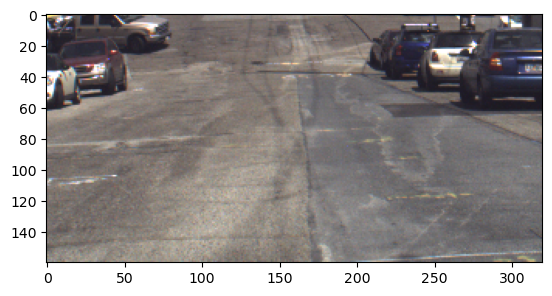

In [1634]:
take_idx = 11
img_idx = 0
interval_idx = 0
plt.imshow(list(vds[take_idx][img_idx])[interval_idx])

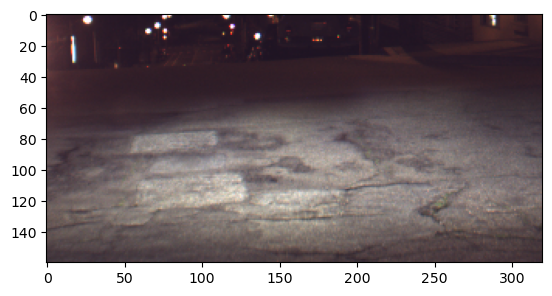

In [1496]:
take_idx = 3800
plt.imshow(vds[take_idx][0])

In [1574]:
dataset = tf.data.Dataset.range(100).window(10, shift = 50, stride=5,
                                          drop_remainder=True)
for window in dataset:
  print(list(window.as_numpy_iterator()))

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
[50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


# Gen 1

In [1328]:
class DatasetGenerator(tf.data.Dataset):

    @staticmethod
    def get_inteval(x, outputs):

      angle, speed = outputs
      return x.batch(timesteps).get_single_element()[:-1:interval], (angle.batch(timesteps).get_single_element()[-1], speed.batch(timesteps).get_single_element()[-1])
    
    def _generator(filename):

        dataset = tf.data.TFRecordDataset(filename)
        dataset = dataset.map(_parse_features, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.skip(tf.random.uniform(shape=(), minval=0, maxval=shift_amount, dtype=tf.int64))
        dataset = dataset.window(timesteps, shift=shift_amount, drop_remainder=True)
        dataset = dataset.map(DatasetGenerator(filename).get_inteval)
        
        for img, (angle, speed) in dataset:
            yield(img, (angle, speed))

    def __new__(self, filename):

        output_signature = ( tf.TensorSpec(shape=(10, 160, 320, 3), dtype=tf.uint8, name=None), 
                            (tf.TensorSpec(shape=(), dtype=tf.float32, name=None), tf.TensorSpec(shape=(), dtype=tf.float32, name=None)))

        return tf.data.Dataset.from_generator(self._generator,
                                              output_signature = output_signature,
                                              args=(filename,))

ds_train = tf.data.Dataset.from_tensor_slices(dataset_files)
ds_train = ds_train.interleave(lambda x: DatasetGenerator(x),
                               num_parallel_calls = tf.data.AUTOTUNE, 
                               deterministic=True)
ds_train = ds_train.batch(8, drop_remainder=True)
ds_train = ds_train.prefetch(AUTOTUNE)

In [1329]:
b = ds_train.take(10)

In [1331]:
# b = list(b)

In [ ]:
take_idx = 0
batch_idx = 23 # 64
window_idx = 5+2
plt.imshow(b[take_idx][0][batch_idx][window_idx])

# Gen 2

In [1227]:
def get_inteval(x, outputs):

    angle, speed = outputs
    timesteps = 50
    interval = 10
    return x.batch(timesteps).get_single_element()[:-1:interval], (angle.batch(timesteps).get_single_element()[-1], speed.batch(timesteps).get_single_element()[-1])

In [1294]:
class DatasetGenerator():

    @staticmethod
    def get_inteval(x, outputs):

      angle, speed = outputs
      return x.batch(timesteps).get_single_element()[:-1:interval], (angle.batch(timesteps).get_single_element()[-1], speed.batch(timesteps).get_single_element()[-1])

    def __call__(self, filename):

        dataset = tf.data.TFRecordDataset(filename)
        dataset = dataset.map(_parse_features, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.skip(tf.random.uniform(shape=(), minval=0, maxval=shift_amount, dtype=tf.int64))
        dataset = dataset.window(timesteps, shift=shift_amount, drop_remainder=True)
        dataset = dataset.map(DatasetGenerator.get_inteval)
        
        for img, (angle, speed) in dataset:
            yield(img, (angle, speed))


output_signature = ( tf.TensorSpec(shape=(10, 160, 320, 3), dtype=tf.uint8, name=None), 
                            (tf.TensorSpec(shape=(), dtype=tf.float32, name=None), tf.TensorSpec(shape=(), dtype=tf.float32, name=None)))
ds_train = tf.data.Dataset.from_tensor_slices(dataset_files)
ds_train = ds_train.interleave(lambda filename: tf.data.Dataset.from_generator(DatasetGenerator(),
                                                                               output_signature=output_signature,
                                                                               args=[filename]),
                               cycle_length=4, 
                               num_parallel_calls = tf.data.AUTOTUNE)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(AUTOTUNE)

In [1295]:
b = ds_train.take(10)

In [1296]:
out = list(b)

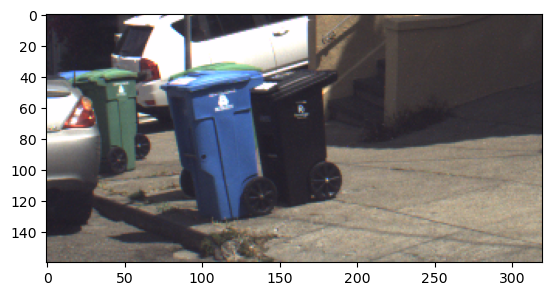

In [1312]:
take_idx = 0
batch_idx = 4
window_idx = 8
plt.imshow(out[take_idx][0][batch_idx][window_idx])

# Works

In [1258]:
class generator():
    
    @staticmethod
    def _parse_features(example_proto):

      features = {'X': tf.io.FixedLenFeature([], dtype=tf.string), 
                  'steering_angle': tf.io.FixedLenFeature([], dtype=tf.float32), 
                  'speed': tf.io.FixedLenFeature([], dtype=tf.float32),}
      parsed_features = tf.io.parse_single_example(example_proto, features)
                    
      image = tf.io.decode_raw(parsed_features['X'], tf.uint8)
      image = tf.reshape(image, shape=(3, 160, 320))
      image = tf.transpose(image, [1, 2, 0])

      speed = parsed_features['speed']
      angle = parsed_features['steering_angle']

      return image, (angle, speed)

    @staticmethod
    def get_inteval(x, outputs):

      angle, speed = outputs
      return x.batch(timesteps).get_single_element()[:-1:interval], (angle.batch(timesteps).get_single_element()[-1], speed.batch(timesteps).get_single_element()[-1])

    def __call__(self, tfRecord):

      dataset = tf.data.TFRecordDataset(tfRecord)
      dataset = dataset.map(generator._parse_features, num_parallel_calls=tf.data.AUTOTUNE)
      dataset = dataset.skip(tf.random.uniform(shape=(), minval=0, maxval=shift_amount, dtype=tf.int64))
      dataset = dataset.window(timesteps, shift=shift_amount, drop_remainder=True)
      dataset = dataset.map(generator.get_inteval)

      for img, (angle, speed) in dataset:
          yield(img, angle)

method = 'bucketize_angle'
if method == 'normal': output_signature = (tf.TensorSpec(shape=(number_outputs,) + img_shape, dtype=tf.uint8, name=None), {'angle': tf.TensorSpec(shape=(), dtype=tf.float64, name=None), 'speed': tf.TensorSpec(shape=(), dtype=tf.float64, name=None)})
if method == 'bucketize': output_signature = (tf.TensorSpec(shape=(number_outputs,) + img_shape, dtype=tf.uint8, name=None), {'sign': tf.TensorSpec(shape=(), dtype=tf.float64, name=None), 'magnitude': tf.TensorSpec(shape=(90,), dtype=tf.float64, name=None), 'speed': tf.TensorSpec(shape=(), dtype=tf.float64, name=None)})
if method == 'only_angle': output_signature = (tf.TensorSpec(shape=(number_outputs,) + img_shape, dtype=tf.uint8, name=None), tf.TensorSpec(shape=(), dtype=tf.float64, name=None))
if method == 'bucketize_angle': output_signature = (tf.TensorSpec(shape=(number_outputs,) + img_shape, dtype=tf.uint8, name=None), tf.TensorSpec(shape=(), dtype=tf.float64, name=None))
if method == 'one_hot_bucket_angle': output_signature = (tf.TensorSpec(shape=(number_outputs,) + img_shape, dtype=tf.uint8, name=None), tf.TensorSpec(shape=(90,), dtype=tf.float64, name=None))

ds_train = tf.data.Dataset.from_tensor_slices(dataset_files)
ds_train = ds_train.interleave(lambda filename: tf.data.Dataset.from_generator(generator(),
                                                                               output_signature=output_signature,
                                                                               args=[filename]),
                               cycle_length=4, 
                               num_parallel_calls = AUTOTUNE)

ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(AUTOTUNE)

In [1259]:
b = ds_train.take(10)

In [1260]:
b = list(b)

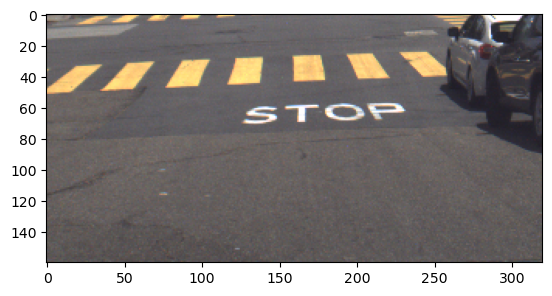

In [1290]:
take_idx = 8
batch_idx = 0 # 64
window_idx = 5+2
plt.imshow(b[take_idx][0][batch_idx][window_idx])